# Notebook 7 - Creating Orientation Data from Strike Data

[GemGIS](https://github.com/cgre-aachen/gemgis) is a package for geographic information processing for geomodeling. In particular, data is prepared for direct use in [GemPy](https://github.com/cgre-aachen/gempy) via a GemPy Data Class. The package provides functions to process spatial data such as vector data (shape files, geojson files, geopackages), raster data (tiff-files), data retrieved from WMS Services or KML/XML files. 

At a later stage, functionality will be added to interactively add interfaces and orientations for a model, chosing the extent, defining custom sections and more. In addition, functionality will be provided to export data from GemPy into Geoinformation Systems such as QGIS or ArcGIS and Google Earth. 

# Overview

This notebook will present how vector data can be loaded into GemGIS with the [GeoPandas](https://geopandas.org/) package and how it can be manipulated for the usage in [GemPy](https://github.com/cgre-aachen/gempy). This includes the extraction of coordinates and height values from a GeoDataFrame and DEM, respectively. 

- [What are Interfaces and Orientations?](#intandor)
- [What is GemPy?](#gempy)
- [Downloading and Installing GemGIS](#gemgis)
- [Structure of GemGIS](#structure)
- [Importing Libraries](#import)
- [Version Reports](#vreport)

- [Example 1 - Extract Orientations from a W-E striking planar surface](#ex1)
- [Example 2 - Extract Orientations from a NW-SE striking fold](#ex2)
- [Example 3 - Extract Orientations from a surface with curved strike lines](#ex3)
- [Example 4 - Extract Orientations from multiple surfaces and a fault](#ex4)


<a id='intandor'></a>
## What are Interfaces and Orientations?
`GemPy`uses an implicit modeling approach based on the potential field method to create geological models. The only input data required are interfaces (layer boundaries in outcrops or in wells) and orientations (dip and azimuth values of a given orientation). The necessary information for interfaces are the `X`,`Y` and `Z`coordinates as well as the `formation`. Please be aware that `GemPy` is always referring to the base of a formation! For orientations, `X`,`Y` and `Z`coordinates, the `formation` and `dip`, `azimuth` and a `polarity` values is needed. The polarity is usually set to 1. 

Strike, in geology, is the direction of the line formed by the intersection of a fault, bed, or other planar feature and a horizontal plane. Strike indicates the dip orientation or position of linear structural features such as faults, beds, joints, and folds.

<img src="../data/Images/orientations.jpg" width="500">

Source: https://www.britannica.com/science/strike-geology <br>
Image from: Geological Structures: a Practical Introduction -  John W.F. Waldron and Morgan Snyder 


<a id='gempy'></a>
## What is GemPy?

`GemPy` is a Python-based, **open-source geomodeling library**. It is
capable of constructing complex **3D geological models** of folded
structures, fault networks and unconformities, based on the underlying
powerful **implicit representation** approach. `GemPy` was designed from the
ground up to support easy embedding in probabilistic frameworks for the
uncertainty analysis of subsurface structures.

Check out the documentation either on the main website (https://www.gempy.org/) or the specific docs site (http://docs.gempy.org/).

- GemPy Installation Help: https://docs.gempy.org/installation.html
- GemPy Tutorials: https://docs.gempy.org/tutorials/index.html
- GemPy Examples: https://docs.gempy.org/examples/index.html
- GemPy Repository: https://github.com/cgre-aachen/gempy
- GemPy Tutorial Video: https://youtu.be/n0btC5Zilyc




<a id='gemgis'></a>
## Downloading and installing GemGIS

`GemGIS` is currently under development and only available at https://github.com/cgre-aachen/gemgis. pip and conda versions including a documentations page will follow.

<a id='structure'></a>
## Structure of GemGIS

The core of `GemGIS` is made of the `GemPyData` class (`gemgis.py`). Its attributes can directly be utilized by `GemPy` making it easier for users to load data. Methods of the `GemPyData` class allow users to directly set these attributes. Multiple other files contain functions to manipulate vector data, raster data, etc.:

* `gemgis.py` - core file containing the `GemPyData` class
* `vector.py` - file containing functions to manipulate vector data
* `raster.py` - file containing functions to manipulate raster data
* `utils.py` - file containing utility functions frequently used for the manipulation of vector/raster data
* `wms.py` - file containing methods to load WMS services as arrays/rasters
* `visualization.py` - file containing functions to simplify plotting of spatial data
* `postprocessing.py` - file containing functions to postprocess GemPy geo_model data




If you have any problems using GemGIS, find a bug or have an idea for a new feature, open an issue at https://github.com/cgre-aachen/gemgis/issues. 

<a id='import'></a>
# Importing Libraries

Apart from creating a GemPyData class in later tutorials, GemGIS is working with pure GeoDataFrames, Rasterio files and NumPy arrays to provide the user with easy data handling. ***Currently, geopandas version 0.6.1 is the latest stable version that is supported by GemGIS***. A general introduction to working with rasters and Rasterio objects in GemGIS is provided in the working with raster files notebook.

In [1]:
import sys
sys.path.append('../../gemgis')
import gemgis as gg
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
print(gg)

<module 'gemgis' from '../../gemgis\\gemgis\\__init__.py'>


<a id='vreport'></a>
# Version Reports
Reporting your Python environment's package versions and hardware resources by Scooby - https://github.com/banesullivan/scooby. This overview shows the packages and their versions used to run this notebook. Upgrading or downgrading to older or newer versions may break the notebook.

In [2]:
gg.Report()

--------------------------------------------------------------------------------
  Date: Wed Jul 29 20:17:37 2020 W. Europe Daylight Time

                OS : Windows
            CPU(s) : 24
           Machine : AMD64
      Architecture : 64bit
               RAM : 63.9 GB
       Environment : Jupyter

  Python 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]

              json : 2.0.9
             numpy : 1.18.5
            scooby : 0.5.2
            owslib : 0.17.0
            pandas : 1.0.5
           shapely : 1.6.4.post1
           pyvista : 0.25.3
          rasterio : 1.0.21
         geopandas : 0.6.1
          requests : 2.24.0
             scipy : 1.5.0
        matplotlib : 3.2.2

  Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------

<a id='ex1'></a>
# Example 1 - Extract Orientations from a W-E striking planar surface

As a first example we will extract orientation values based on intersections of layer boundaries (purple) with topography (green). Intersecting points with the same altitude can be connected to form strike lines (purple lines). These lines represent isolines of outcropping layers assuming that the topography is horizontal (green planes). Based on the contour spacing and the height difference, the slope and hence the dipping angle $\theta$ can be estimated according to

$$tan(\theta) = m = \frac{\Delta y}{\Delta x}$$

and 

$$\theta = tan^{-1}\left( \frac{\Delta y}{\Delta x}\right)$$.

<img src="../data/Images/orientations.jpg" width="500">

Image from: Geological Structures: a Practical Introduction -  John W.F. Waldron and Morgan Snyder 

## Load Data

In [3]:
geological_map = rasterio.open('../../gemgis/data/Test1/task1.tif')
gdf = gpd.read_file('../../gemgis/data/Test1/points_strike.shp')

## Inspect Data

**In order for GemGIS to be able to calculate the orientations, a unique ID needs to be provided for each set of strike points. GemGIS will then calculate the strike between strike line 1 and 2, 2 and 3 and so forth. This way, altitudes can be present multiple times as it is the common case for folds.**

In [4]:
gdf.head()

id    Z formation                 geometry
0   2  400       Ton   POINT (62.513 382.832)
1   3  500       Ton  POINT (141.489 555.155)
2   4  600       Ton  POINT (191.943 720.949)
3   5  700       Ton  POINT (287.541 893.302)
4   5  700       Ton  POINT (481.908 893.302)

## Set Extent

In [5]:
extent = gg.utils.set_extent(0,972,0,1069)
extent

[0, 972, 0, 1069]

## Plot Data

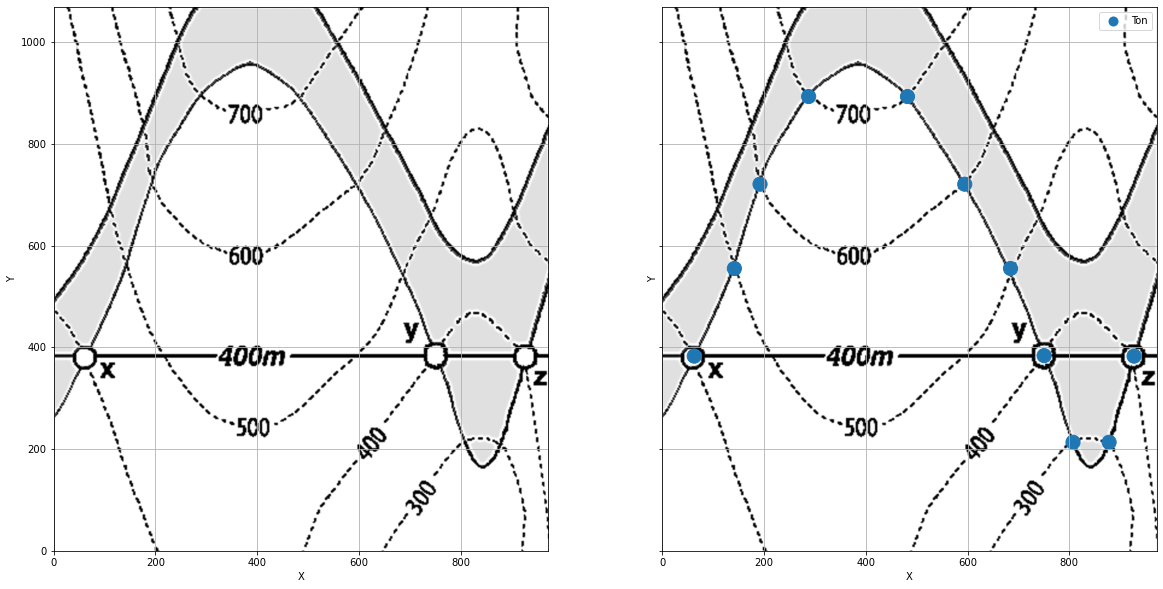

In [6]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
# Plotting the interfaces on the geological map
gdf.plot(ax=ax2, column = 'formation', legend = True, s = 200)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1]);

## Create LineString GeoDataFrame

We are creating a LineString GeoDataFrame based on the points to visualize the strike lines. 

In [7]:
linestring_gdf = gg.utils.create_linestring_gdf(gdf)
linestring_gdf

geometry    Z formation
0      LINESTRING (807.441 213.514, 878.392 213.516)  300       Ton
1  LINESTRING (62.513 382.832, 750.576 383.831, 9...  400       Ton
2      LINESTRING (141.489 555.155, 684.515 555.153)  500       Ton
3      LINESTRING (191.943 720.949, 594.500 720.942)  600       Ton
4      LINESTRING (287.541 893.302, 481.908 893.302)  700       Ton

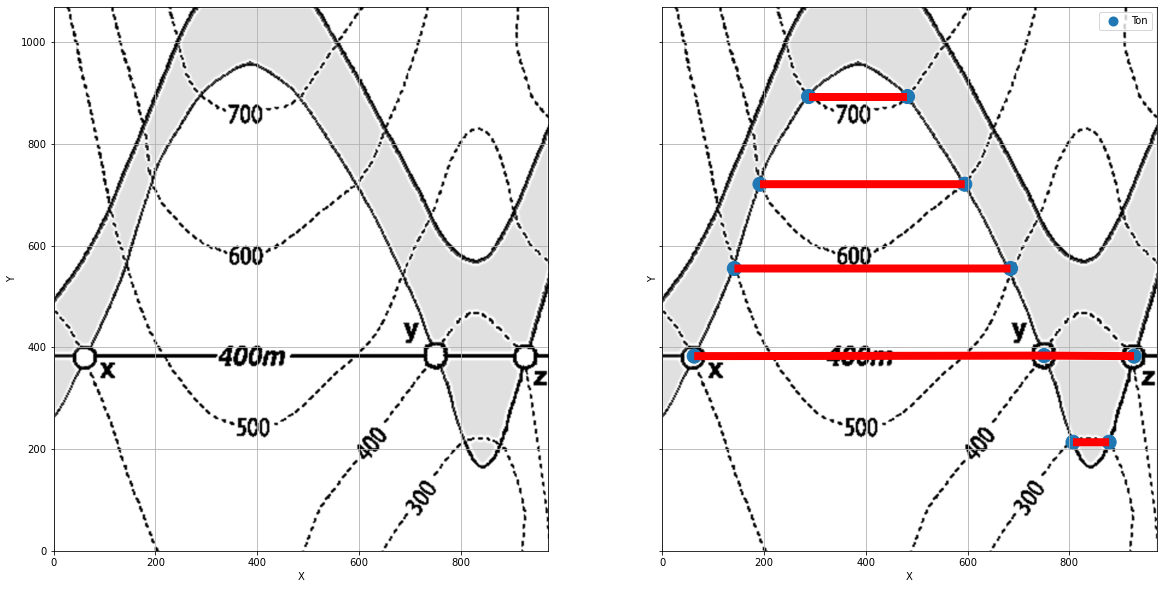

In [8]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
# Plotting the interfaces on the geological map
gdf.plot(ax=ax2, column = 'formation', legend = True, s = 200)
linestring_gdf.plot(ax=ax2, linewidth=8, color='red')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1]);

## Calculate Orientations

Orientations are calculated for one formation with eigenvector analysis. The orientations are then returned for the midpoint of each strike line and the DataFrame can directly be used for `GemPy`. Examples with multiple formations follow.

In [9]:
orientations = gg.utils.calculate_orientations(gdf)
orientations

X           Y      Z        dip     azimuth  polarity formation
0  513.316322  451.959797  440.0  30.167326  179.982934         1       Ton
1  403.111746  638.049949  550.0  31.097049  180.000516         1       Ton
2  388.972932  807.123894  650.0  30.122015  180.000857         1       Ton
3  384.724148  893.302149  700.0  90.000000  180.000000         1       Ton

## Plot Orientations

(0.0, 972.0)

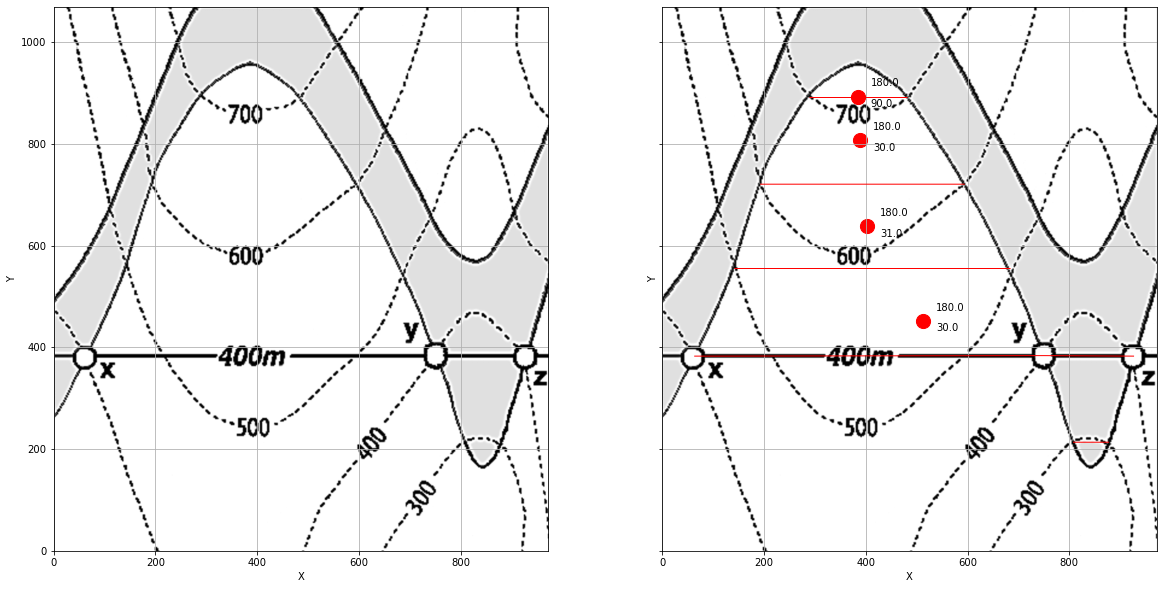

In [10]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(
    ncols=2, sharex=True, sharey=True, figsize=(20, 10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin='lower', cmap='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2], extent[3])
ax1.set_xlim(extent[0], extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(geological_map.read(1)), origin='lower', cmap='gray')
# Plotting the interfaces on the geological map
ax2.scatter(orientations['X'], orientations['Y'], s=200, color='red')
[ax2.text(orientations['X'][i]+25, orientations['Y'][i]+20,
          s=round(orientations['azimuth'][i])) for i in range(len(orientations))]
[ax2.text(orientations['X'][i]+25, orientations['Y'][i]-20,
          s=round(orientations['dip'][i])) for i in range(len(orientations))]
linestring_gdf.plot(ax=ax2, linewidth=1, color='red')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2], extent[3])
ax1.set_xlim(extent[0], extent[1])

<a id='ex2'></a>
# Example 2 - Extract Orientations from a NW-SE striking fold

The second example shows a NW-SE striking anticline. 

<img src='../../gemgis/data/examples/example2/task2.png' width="300">

## Load Data

In [11]:
geological_map = rasterio.open('../../gemgis/data/examples/example2/task2.tif')
gdf = gpd.read_file('../../gemgis/data/examples/example2/lines_strike.shp')

## Inspect Data

In [12]:
gdf.head()

id    Z formation                                   geometry
0   1  100    Layer1   LINESTRING (2.577 102.527, 78.137 1.951)
1   2  150    Layer1  LINESTRING (3.720 276.250, 208.683 2.713)
2   3  200    Layer1  LINESTRING (1.942 442.607, 335.546 1.697)
3   4  250    Layer1  LINESTRING (1.307 583.693, 438.662 6.395)
4   5  300    Layer1  LINESTRING (1.815 721.604, 544.572 2.967)

## Set Extent

In [13]:
extent = gg.utils.set_extent(0,865,0,866)
extent

[0, 865, 0, 866]

## Plot Data

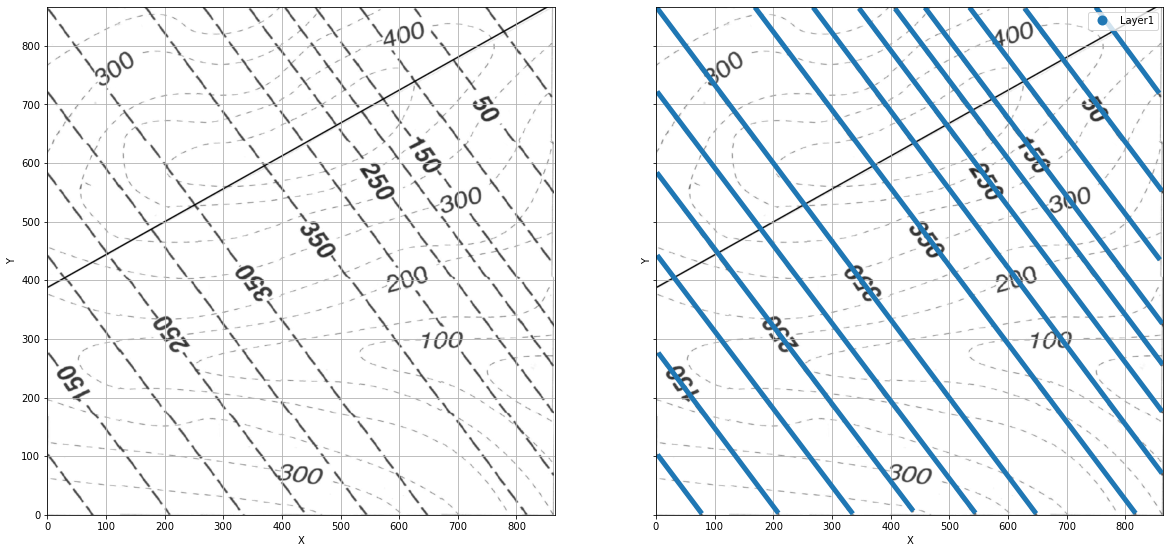

In [14]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
# Plotting the interfaces on the geological map
gdf.plot(ax=ax2, column = 'formation', legend = True, linewidth = 5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1]);

## Calculate Orientations

Orientations are calculated for one formation with eigenvector analysis. The orientations are then returned for the midpoint of each strike line and the DataFrame can directly be used for `GemPy`. Examples with multiple formations follow.

In [15]:
orientations = gg.utils.calculate_orientations(gdf)
orientations

X           Y      Z        dip     azimuth  polarity formation
0    73.279194   95.859905  125.0  25.460798  233.147077         1    Layer1
1   137.472754  180.816368  175.0  26.627645  232.961921         1    Layer1
2   194.364376  258.597882  225.0  30.508464  232.865763         1    Layer1
3   246.589107  328.664740  275.0  31.065011  232.904430         1    Layer1
4   298.988450  397.810919  325.0  30.774233  233.059777         1    Layer1
5   408.946113  433.653911  350.0   0.000000    0.000000         1    Layer1
6   529.205859  451.019825  325.0  32.587961   53.108498         1    Layer1
7   584.922821  494.037764  275.0  38.631888   53.130774         1    Layer1
8   620.162609  539.881237  225.0  45.663765   53.067311         1    Layer1
9   648.367938  577.655596  175.0  50.218861   53.074811         1    Layer1
10  678.926698  622.800209  125.0  39.116555   53.040008         1    Layer1
11  721.376795  678.903703   75.0  34.105446   52.994837         1    Layer1
12  774.937998  749.973086   25.0  27.224555   53.147713         1    Layer1

## Plot Orientations

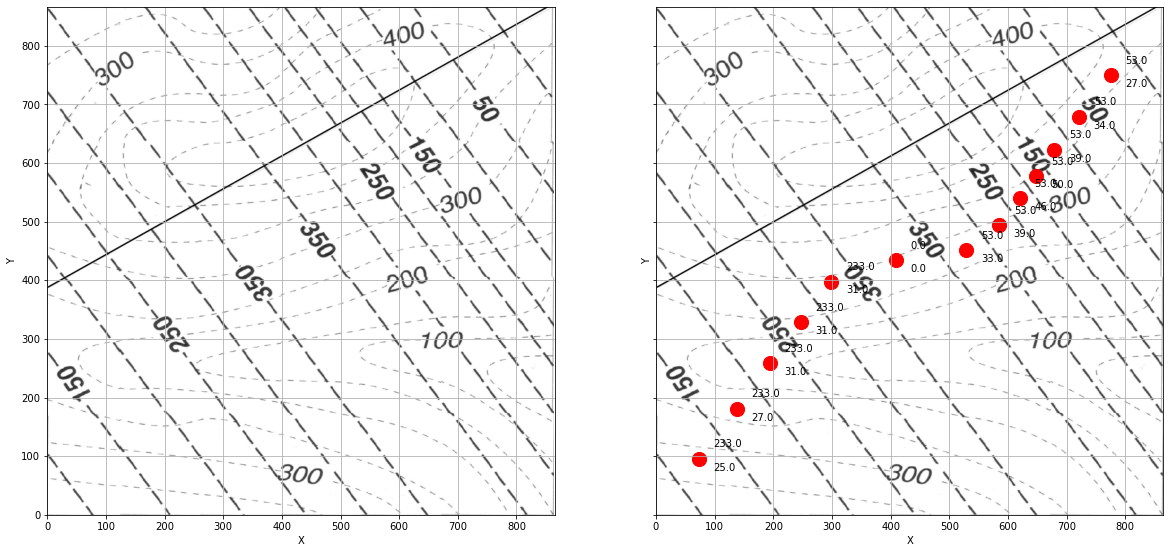

In [16]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(
    ncols=2, sharex=True, sharey=True, figsize=(20, 10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin='lower', cmap='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2], extent[3])
ax1.set_xlim(extent[0], extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(geological_map.read(1)), origin='lower', cmap='gray')
# Plotting the interfaces on the geological map
ax2.scatter(orientations['X'], orientations['Y'], s=200, color='red')
[ax2.text(orientations['X'][i]+25, orientations['Y'][i]+20,
          s=round(orientations['azimuth'][i])) for i in range(len(orientations))]
[ax2.text(orientations['X'][i]+25, orientations['Y'][i]-20,
          s=round(orientations['dip'][i])) for i in range(len(orientations))]

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2], extent[3])
ax1.set_xlim(extent[0], extent[1]);

<a id='intandor'></a>
# Example 3 - Extract Orientations from a surface with curved strike lines 

The third example shows a southward dipping layer with curved strike lines. Orientations for this case can also be calculated with `GemGIS`.


<img src="../../gemgis/data/examples/example3/task3.png" width="300">

## Load Data

In [17]:
geological_map = rasterio.open('../../gemgis/data/examples/example3/raster3.tif')
gdf = gpd.read_file('../../gemgis/data/examples/example3/lines_strike.shp')

## Inspect Data

In [18]:
gdf

id    Z formation                                       geometry
0    1  600    Layer1   LINESTRING (46.044 702.206, 190.042 725.406)
1    2  500    Layer1   LINESTRING (49.510 572.074, 271.908 618.474)
2    3  400    Layer1   LINESTRING (69.244 368.876, 355.641 452.075)
3    4  300    Layer1   LINESTRING (62.310 272.344, 266.042 247.811)
4    5  200    Layer1    LINESTRING (54.844 118.745, 312.974 79.279)
5    6  300    Layer1  LINESTRING (391.907 261.677, 459.106 340.610)
6    7  200    Layer1  LINESTRING (436.706 178.478, 524.172 187.011)
7    8  600    Layer1  LINESTRING (463.373 765.139, 612.705 747.006)
8    9  500    Layer1  LINESTRING (412.173 672.340, 670.304 668.073)
9   10  400    Layer1  LINESTRING (471.906 495.275, 625.505 476.075)
10  11  300    Layer1  LINESTRING (519.906 352.343, 662.838 332.077)

## Set Extent

In [19]:
extent = gg.utils.set_extent(0,700,0,788)
extent

[0, 700, 0, 788]

## Plot Data

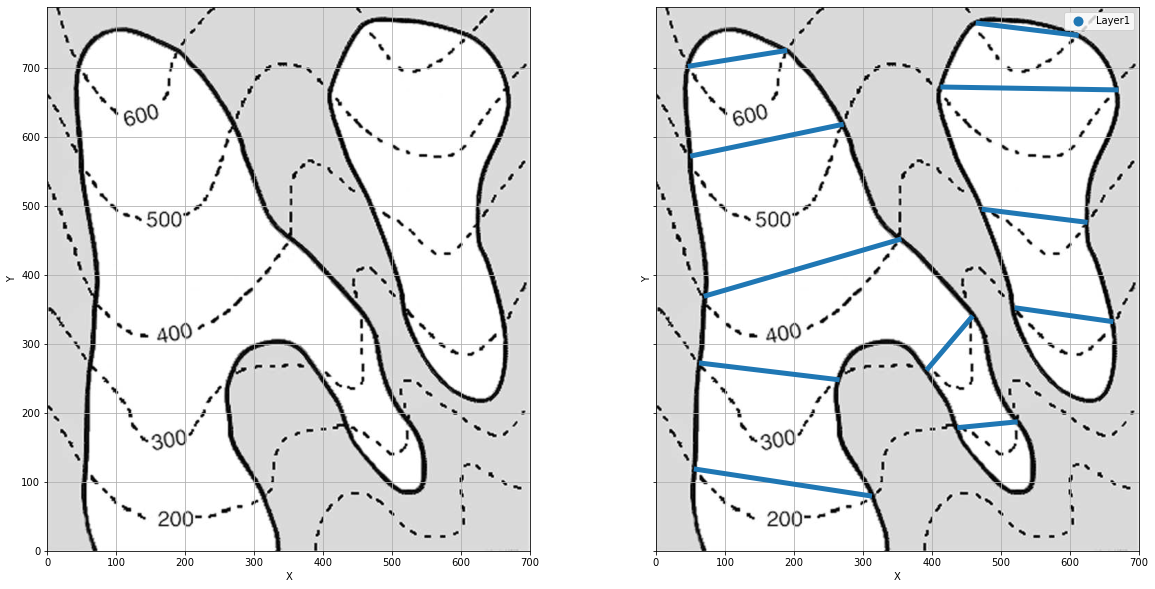

In [20]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
# Plotting the interfaces on the geological map
gdf.plot(ax=ax2, column = 'formation', legend = True, linewidth = 5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1]);

## Calculate Orientations

Orientations are calculated for one formation with eigenvector analysis. The orientations are then returned for the midpoint of each strike line and the DataFrame can directly be used for `GemPy`. Examples with multiple formations follow.

For this example it is important to separate the GeoDataFrame into 4 sub-GeoDataFrames. The first part will represent the the strike lines in the NW (600m-400m), the second the lines in the southwest (300m-200m), the third the lines in the center (300m-200m) and the last one in the NE (600m-300m). 

The orientations are calculated separately and then combined again using `pd.concat([orientations1,...])`

In [21]:
gdf_copy = gdf.copy(deep=True)

In [22]:
gdf1 = gdf_copy[gdf_copy['id']<=3]
gdf1

id    Z formation                                      geometry
0   1  600    Layer1  LINESTRING (46.044 702.206, 190.042 725.406)
1   2  500    Layer1  LINESTRING (49.510 572.074, 271.908 618.474)
2   3  400    Layer1  LINESTRING (69.244 368.876, 355.641 452.075)

In [23]:
gdf2 = gdf_copy[gdf_copy['id'] >3]
gdf2 = gdf2[gdf2['id'] <=5]
gdf2

id    Z formation                                      geometry
3   4  300    Layer1  LINESTRING (62.310 272.344, 266.042 247.811)
4   5  200    Layer1   LINESTRING (54.844 118.745, 312.974 79.279)

In [24]:
gdf3 = gdf_copy[gdf_copy['id'] >5]
gdf3 = gdf3[gdf3['id'] <=7]
gdf3

id    Z formation                                       geometry
5   6  300    Layer1  LINESTRING (391.907 261.677, 459.106 340.610)
6   7  200    Layer1  LINESTRING (436.706 178.478, 524.172 187.011)

In [25]:
gdf4 = gdf_copy[gdf_copy['id'] >7]
gdf4 = gdf4[gdf4['id'] <=11]
gdf4

id    Z formation                                       geometry
7    8  600    Layer1  LINESTRING (463.373 765.139, 612.705 747.006)
8    9  500    Layer1  LINESTRING (412.173 672.340, 670.304 668.073)
9   10  400    Layer1  LINESTRING (471.906 495.275, 625.505 476.075)
10  11  300    Layer1  LINESTRING (519.906 352.343, 662.838 332.077)

In [26]:
orientations1 = gg.utils.calculate_orientations(gdf1)
orientations1

X           Y      Z        dip     azimuth  polarity formation
0  139.376141  654.539975  550.0  38.754019  168.980911         1    Layer1
1  186.575667  502.874831  450.0  27.479387  165.419865         1    Layer1

In [27]:
orientations2 = gg.utils.calculate_orientations(gdf2)
orientations2

X           Y      Z        dip     azimuth  polarity formation
0  174.04246  179.544744  250.0  32.525193  187.992989         1    Layer1

In [28]:
orientations3 = gg.utils.calculate_orientations(gdf3)
orientations3

X           Y      Z        dip     azimuth  polarity formation
0  452.972993  241.944118  250.0  36.349702  148.693439         1    Layer1

In [29]:
orientations4 = gg.utils.calculate_orientations(gdf4)
orientations4

X           Y      Z        dip     azimuth  polarity formation
0  539.638789  713.139387  550.0  49.269965  182.453689         1    Layer1
1  544.972069  577.940744  450.0  28.465597  182.567698         1    Layer1
2  570.038484  413.942391  350.0  36.204884  187.563568         1    Layer1

In [30]:
orientations = pd.concat([orientations1, orientations2, orientations3, orientations4])
orientations

X           Y      Z        dip     azimuth  polarity formation
0  139.376141  654.539975  550.0  38.754019  168.980911         1    Layer1
1  186.575667  502.874831  450.0  27.479387  165.419865         1    Layer1
0  174.042460  179.544744  250.0  32.525193  187.992989         1    Layer1
0  452.972993  241.944118  250.0  36.349702  148.693439         1    Layer1
0  539.638789  713.139387  550.0  49.269965  182.453689         1    Layer1
1  544.972069  577.940744  450.0  28.465597  182.567698         1    Layer1
2  570.038484  413.942391  350.0  36.204884  187.563568         1    Layer1

## Plot Orientations

(0.0, 700.0)

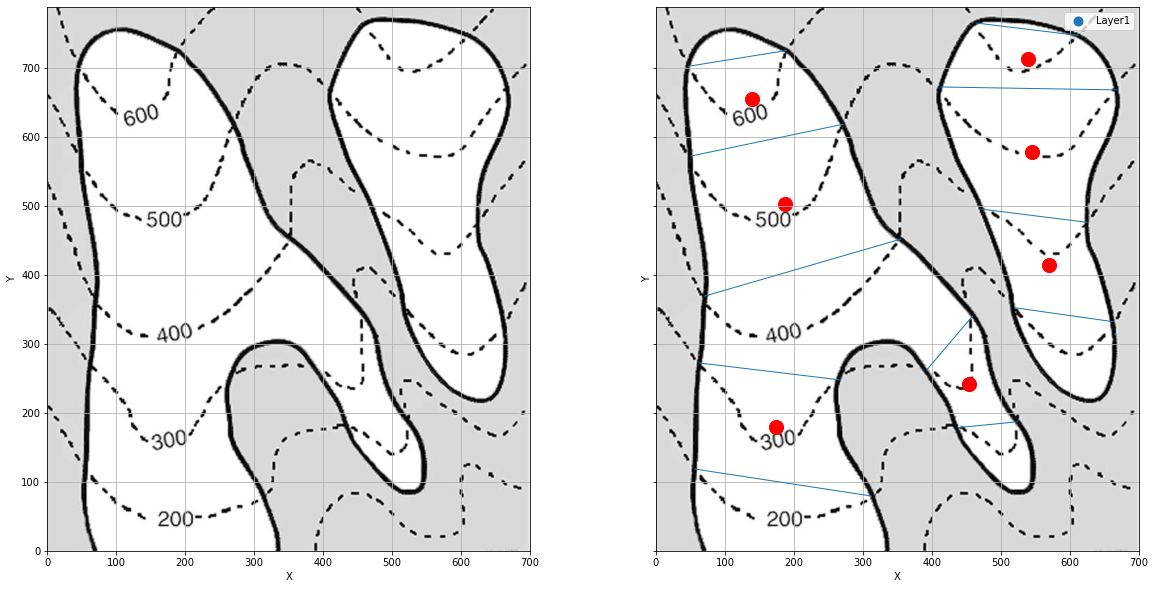

In [31]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(
    ncols=2, sharex=True, sharey=True, figsize=(20, 10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin='lower', cmap='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2], extent[3])
ax1.set_xlim(extent[0], extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(geological_map.read(1)), origin='lower', cmap='gray')
# Plotting the interfaces on the geological map
ax2.scatter(orientations['X'], orientations['Y'], s=200, color='red')
# [ax2.text(orientations['X'][i]+25, orientations['Y'][i]+20,
#           s=round(orientations['azimuth'][i])) for i in range(len(orientations))]
# [ax2.text(orientations['X'][i]+25, orientations['Y'][i]-20,
#           s=round(orientations['dip'][i])) for i in range(len(orientations))]
gdf.plot(ax=ax2, column='formation', legend=True, linewidth=1)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2], extent[3])
ax1.set_xlim(extent[0], extent[1])

In [32]:
orientations

X           Y      Z        dip     azimuth  polarity formation
0  139.376141  654.539975  550.0  38.754019  168.980911         1    Layer1
1  186.575667  502.874831  450.0  27.479387  165.419865         1    Layer1
0  174.042460  179.544744  250.0  32.525193  187.992989         1    Layer1
0  452.972993  241.944118  250.0  36.349702  148.693439         1    Layer1
0  539.638789  713.139387  550.0  49.269965  182.453689         1    Layer1
1  544.972069  577.940744  450.0  28.465597  182.567698         1    Layer1
2  570.038484  413.942391  350.0  36.204884  187.563568         1    Layer1

<a id='ex4'></a>
# Example 4 - Extract Orientations from Inclined Layers separated by a fault.

The fourth example shows 3 southward dipping layers separated by a fault. Orientations for this case can also be calculated with `GemGIS`.


<img src="../../gemgis/data/examples/example4/task4.png" width="300">

## Set Extent, Load Geological Map, Load Colors

In [33]:
extent = gpd.read_file('../../gemgis/data/examples/example4/extent4.shp')
extent = gg.utils.set_extent(gdf=extent)

In [34]:
base_map = rasterio.open('../../gemgis/data/examples/example4/task4.png')
geological_map = gpd.read_file('../../gemgis/data/examples/example4/geolmap4.shp')

C:\Users\user_abuser\Anaconda3\lib\site-packages\rasterio\__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


In [35]:
cols = gg.utils.load_surface_colors('../../gemgis/data/examples/example4/style4.qml', geological_map)
cols

['#b35a2a', '#069a2b', '#525252']

## Load Fault Data and Calculate Orientations

In [36]:
strike_fault = gpd.read_file('../../gemgis/data/examples/example4/lines_strike_fault.shp')
strike_fault

id    Z formation                                       geometry
0   1  400    Fault1  LINESTRING (306.110 484.786, 511.198 451.597)
1   2  500    Fault1  LINESTRING (223.696 514.599, 583.462 453.789)
2   3  600    Fault1  LINESTRING (146.764 542.741, 740.718 440.638)

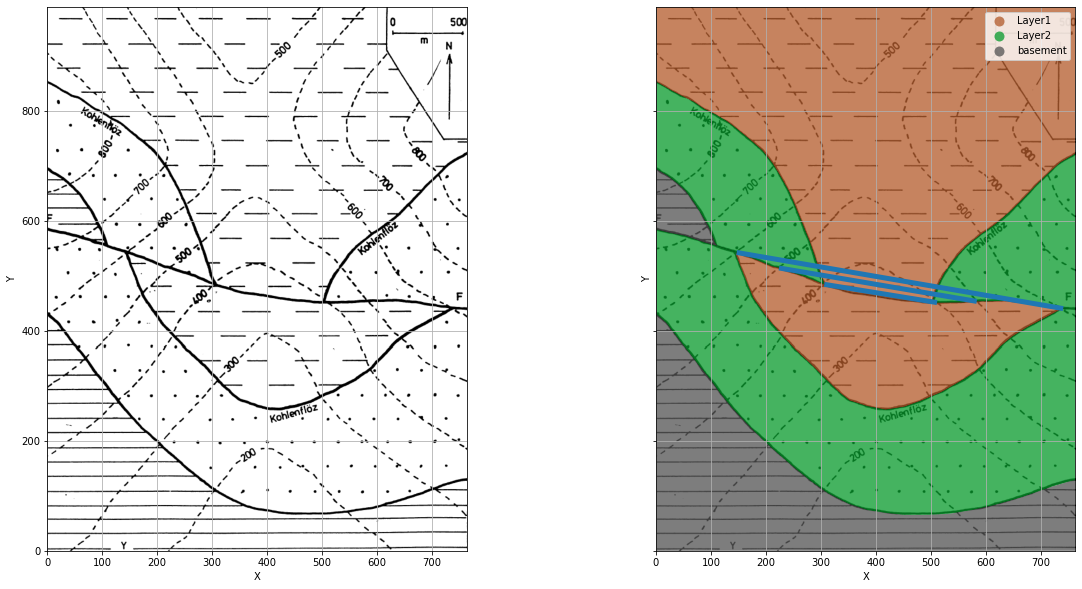

In [37]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
# Plotting the geological map
ax1.imshow(np.flipud(base_map.read(1)), origin = 'lower', cmap ='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(base_map.read(1)), origin = 'lower', cmap ='gray')
# Plotting the different elements on the geological map
geological_map.plot(ax=ax2, column = 'formation', alpha=0.75, legend=True, cmap=ListedColormap(cols))
# topo.plot(ax=ax2, column = 'Z', legend = False, linewidth = 5)
# interfaces.plot(ax=ax2, column = 'formation', legend = True, linewidth = 10)
# orientations.plot(ax=ax2, column = 'formation', legend = False, s = 300)
strike_fault.plot(ax=ax2, column = 'formation', legend = False, linewidth = 5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1]);

Based on the strike lines and the calculated angles, we can conclude that the fault is dipping towards the south. Please take into account that the map was not digitized to scale. So angles are usually higher than expected for certain types of faults!

In [38]:
orientations_fault = gg.utils.calculate_orientations(strike_fault)
orientations_fault 

X           Y      Z        dip     azimuth  polarity formation
0  406.116264  476.192891  450.0  81.498734  189.495426         1    Fault1
1  423.660122  487.941779  550.0  81.938874  189.711081         1    Fault1

## Load Layer Data 
For the strike of the different layers we have to distinguish between layer 1 and layer 2 and between the two fault blocks. 

In [39]:
strike_layers = gpd.read_file('../../gemgis/data/examples/example4/lines_strike_layers.shp')
strike_layers

id    Z formation                                           geometry
0    1  300    Layer1      LINESTRING (311.657 309.826, 497.763 279.280)
1    2  400    Layer1      LINESTRING (228.787 392.414, 586.856 331.605)
2    3  500    Layer1      LINESTRING (173.917 467.931, 644.272 386.192)
3    4  600    Layer1      LINESTRING (147.613 542.600, 740.436 440.496)
4    1  200    Layer2       LINESTRING (306.708 109.579, 546.835 69.416)
5    2  300    Layer2  LINESTRING (205.736 192.450, 205.736 192.450, ...
6    3  400    Layer2      LINESTRING (128.522 273.623, 763.204 175.762)
7    4  500    Layer2  LINESTRING (69.126 348.292, 760.941 241.946, 7...
8    5  600    Layer2  LINESTRING (2.943 428.617, 2.943 428.617, 2.94...
9    5  500    Layer1      LINESTRING (280.687 560.701, 532.976 517.710)
10   6  600    Layer1      LINESTRING (252.969 628.016, 591.240 575.974)
11   7  700    Layer1      LINESTRING (214.503 700.987, 657.423 630.279)
12   8  800    Layer1      LINESTRING (116.642 788.666, 712.293 684.583)
13   6  800    Layer2       LINESTRING (40.277 666.482, 761.507 555.044)
14   7  700    Layer2       LINESTRING (95.147 591.247, 761.507 478.679)

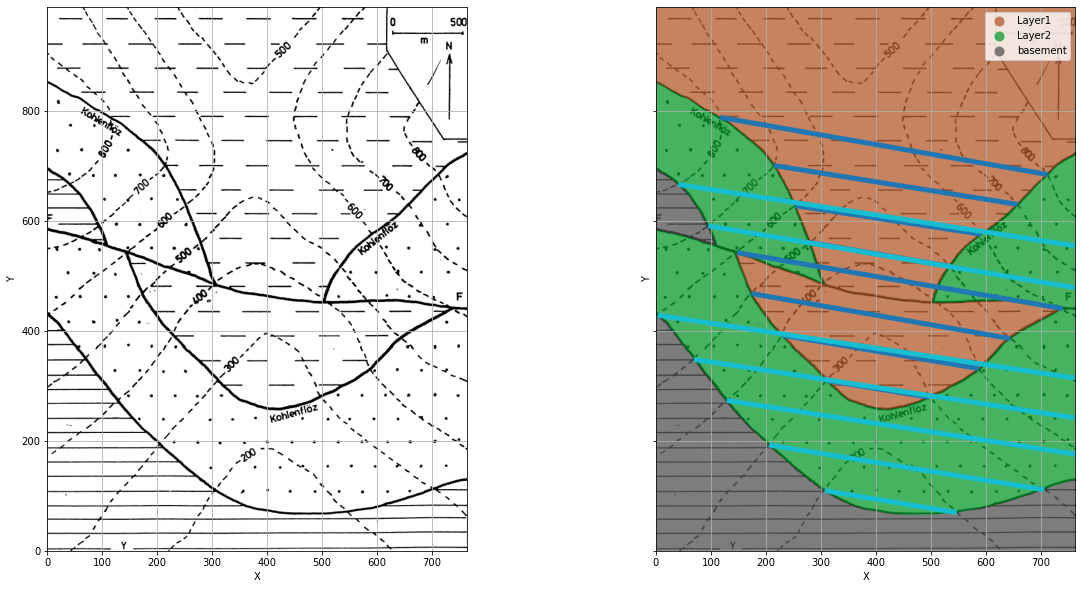

In [40]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
# Plotting the geological map
ax1.imshow(np.flipud(base_map.read(1)), origin = 'lower', cmap ='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(base_map.read(1)), origin = 'lower', cmap ='gray')
# Plotting the different elements on the geological map
geological_map.plot(ax=ax2, column = 'formation', alpha=0.75, legend=True, cmap=ListedColormap(cols))
# topo.plot(ax=ax2, column = 'Z', legend = False, linewidth = 5)
# interfaces.plot(ax=ax2, column = 'formation', legend = True, linewidth = 10)
# orientations.plot(ax=ax2, column = 'formation', legend = False, s = 300)
strike_layers.plot(ax=ax2, column = 'formation', legend = False, linewidth = 5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1]);

## Separate Layers

In [41]:
gdf1 = strike_layers[strike_layers['formation'] == 'Layer1']
gdf1

id    Z formation                                       geometry
0    1  300    Layer1  LINESTRING (311.657 309.826, 497.763 279.280)
1    2  400    Layer1  LINESTRING (228.787 392.414, 586.856 331.605)
2    3  500    Layer1  LINESTRING (173.917 467.931, 644.272 386.192)
3    4  600    Layer1  LINESTRING (147.613 542.600, 740.436 440.496)
9    5  500    Layer1  LINESTRING (280.687 560.701, 532.976 517.710)
10   6  600    Layer1  LINESTRING (252.969 628.016, 591.240 575.974)
11   7  700    Layer1  LINESTRING (214.503 700.987, 657.423 630.279)
12   8  800    Layer1  LINESTRING (116.642 788.666, 712.293 684.583)

In [42]:
gdf2 = strike_layers[strike_layers['formation'] == 'Layer2']
gdf2

id    Z formation                                           geometry
4    1  200    Layer2       LINESTRING (306.708 109.579, 546.835 69.416)
5    2  300    Layer2  LINESTRING (205.736 192.450, 205.736 192.450, ...
6    3  400    Layer2      LINESTRING (128.522 273.623, 763.204 175.762)
7    4  500    Layer2  LINESTRING (69.126 348.292, 760.941 241.946, 7...
8    5  600    Layer2  LINESTRING (2.943 428.617, 2.943 428.617, 2.94...
13   6  800    Layer2       LINESTRING (40.277 666.482, 761.507 555.044)
14   7  700    Layer2       LINESTRING (95.147 591.247, 761.507 478.679)

In [43]:
gdf1_south = gdf1[gdf1['id']<= 4]
gdf1_south

id    Z formation                                       geometry
0   1  300    Layer1  LINESTRING (311.657 309.826, 497.763 279.280)
1   2  400    Layer1  LINESTRING (228.787 392.414, 586.856 331.605)
2   3  500    Layer1  LINESTRING (173.917 467.931, 644.272 386.192)
3   4  600    Layer1  LINESTRING (147.613 542.600, 740.436 440.496)

In [44]:
gdf1_north = gdf1[gdf1['id']> 4]
gdf1_north

id    Z formation                                       geometry
9    5  500    Layer1  LINESTRING (280.687 560.701, 532.976 517.710)
10   6  600    Layer1  LINESTRING (252.969 628.016, 591.240 575.974)
11   7  700    Layer1  LINESTRING (214.503 700.987, 657.423 630.279)
12   8  800    Layer1  LINESTRING (116.642 788.666, 712.293 684.583)

In [45]:
gdf2_south = gdf2[gdf2['id']<= 5]
gdf2_south

id    Z formation                                           geometry
4   1  200    Layer2       LINESTRING (306.708 109.579, 546.835 69.416)
5   2  300    Layer2  LINESTRING (205.736 192.450, 205.736 192.450, ...
6   3  400    Layer2      LINESTRING (128.522 273.623, 763.204 175.762)
7   4  500    Layer2  LINESTRING (69.126 348.292, 760.941 241.946, 7...
8   5  600    Layer2  LINESTRING (2.943 428.617, 2.943 428.617, 2.94...

In [46]:
gdf2_north = gdf2[gdf2['id']> 5]
gdf2_north

id    Z formation                                      geometry
13   6  800    Layer2  LINESTRING (40.277 666.482, 761.507 555.044)
14   7  700    Layer2  LINESTRING (95.147 591.247, 761.507 478.679)

## Calculate Orientations

In [47]:
orientations1_south = gg.utils.calculate_orientations(gdf1_south)
orientations1_south

X           Y      Z        dip     azimuth  polarity formation
0  406.265757  328.281300  350.0  56.163477  189.570970         1    Layer1
1  408.457730  394.535449  450.0  57.248407  189.777815         1    Layer1
2  426.559183  459.304713  550.0  55.203043  189.805652         1    Layer1

In [48]:
orientations1_north = gg.utils.calculate_orientations(gdf1_north)
orientations1_north

X           Y      Z        dip     azimuth  polarity formation
0  414.467978  570.600370  550.0  57.203244  189.077735         1    Layer1
1  429.033991  633.814040  650.0  56.966206  188.951028         1    Layer1
2  425.215716  701.128821  750.0  56.388040  189.612656         1    Layer1

In [49]:
orientations2_south = gg.utils.calculate_orientations(gdf2_south)
orientations2_south

X           Y           Z        dip     azimuth  polarity  \
0  483.439365  128.124880  271.428571  56.516928  189.263941         1   
1  488.894044  166.752090  328.571429  54.755503  189.050624         1   
2  496.546757  256.313880  460.000000  57.001197  188.749272         1   
3  337.253964  347.483791  557.142857  54.820677  188.643271         1   

  formation  
0    Layer2  
1    Layer2  
2    Layer2  
3    Layer2

In [50]:
orientations2_north = gg.utils.calculate_orientations(gdf2_north)
orientations2_north

X           Y      Z        dip     azimuth  polarity formation
0  414.609395  572.863052  750.0  54.784035  189.154487         1    Layer2

## Merge DataFrames

In [51]:
orientations_coords = pd.concat([orientations_fault, orientations1_south, orientations1_north, orientations2_south, orientations2_north]).reset_index()
orientations_coords

index           X           Y           Z        dip     azimuth  \
0       0  406.116264  476.192891  450.000000  81.498734  189.495426   
1       1  423.660122  487.941779  550.000000  81.938874  189.711081   
2       0  406.265757  328.281300  350.000000  56.163477  189.570970   
3       1  408.457730  394.535449  450.000000  57.248407  189.777815   
4       2  426.559183  459.304713  550.000000  55.203043  189.805652   
5       0  414.467978  570.600370  550.000000  57.203244  189.077735   
6       1  429.033991  633.814040  650.000000  56.966206  188.951028   
7       2  425.215716  701.128821  750.000000  56.388040  189.612656   
8       0  483.439365  128.124880  271.428571  56.516928  189.263941   
9       1  488.894044  166.752090  328.571429  54.755503  189.050624   
10      2  496.546757  256.313880  460.000000  57.001197  188.749272   
11      3  337.253964  347.483791  557.142857  54.820677  188.643271   
12      0  414.609395  572.863052  750.000000  54.784035  189.154487   

    polarity formation  
0          1    Fault1  
1          1    Fault1  
2          1    Layer1  
3          1    Layer1  
4          1    Layer1  
5          1    Layer1  
6          1    Layer1  
7          1    Layer1  
8          1    Layer2  
9          1    Layer2  
10         1    Layer2  
11         1    Layer2  
12         1    Layer2

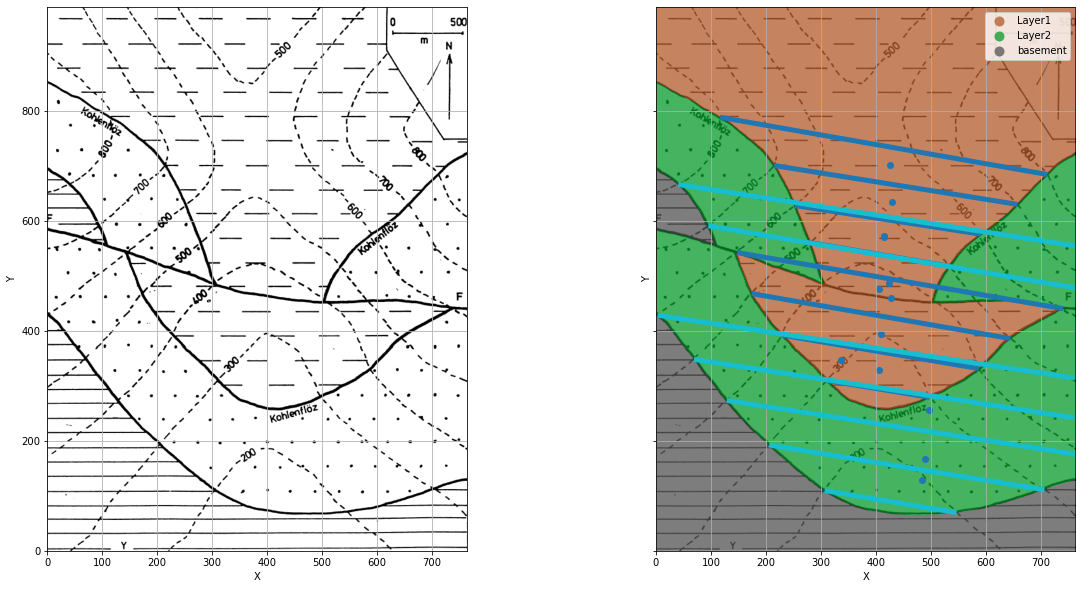

In [52]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
# Plotting the geological map
ax1.imshow(np.flipud(base_map.read(1)), origin = 'lower', cmap ='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(base_map.read(1)), origin = 'lower', cmap ='gray')
# Plotting the different elements on the geological map
geological_map.plot(ax=ax2, column = 'formation', alpha=0.75, legend=True, cmap=ListedColormap(cols))
# topo.plot(ax=ax2, column = 'Z', legend = False, linewidth = 5)
# interfaces.plot(ax=ax2, column = 'formation', legend = True, linewidth = 10)
ax2.scatter(orientations_coords['X'], orientations_coords['Y'])
strike_layers.plot(ax=ax2, column = 'formation', legend = False, linewidth = 5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1]);

In [53]:
orientations_coords

index           X           Y           Z        dip     azimuth  \
0       0  406.116264  476.192891  450.000000  81.498734  189.495426   
1       1  423.660122  487.941779  550.000000  81.938874  189.711081   
2       0  406.265757  328.281300  350.000000  56.163477  189.570970   
3       1  408.457730  394.535449  450.000000  57.248407  189.777815   
4       2  426.559183  459.304713  550.000000  55.203043  189.805652   
5       0  414.467978  570.600370  550.000000  57.203244  189.077735   
6       1  429.033991  633.814040  650.000000  56.966206  188.951028   
7       2  425.215716  701.128821  750.000000  56.388040  189.612656   
8       0  483.439365  128.124880  271.428571  56.516928  189.263941   
9       1  488.894044  166.752090  328.571429  54.755503  189.050624   
10      2  496.546757  256.313880  460.000000  57.001197  188.749272   
11      3  337.253964  347.483791  557.142857  54.820677  188.643271   
12      0  414.609395  572.863052  750.000000  54.784035  189.154487   

    polarity formation  
0          1    Fault1  
1          1    Fault1  
2          1    Layer1  
3          1    Layer1  
4          1    Layer1  
5          1    Layer1  
6          1    Layer1  
7          1    Layer1  
8          1    Layer2  
9          1    Layer2  
10         1    Layer2  
11         1    Layer2  
12         1    Layer2